In [45]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Literal
from IPython.display import Image
import operator
from dotenv import load_dotenv
import os

load_dotenv()
model = ChatOpenAI(model=os.getenv("strgpt_model"))

In [46]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description='sentiment of review')
sentiment_model = model.with_structured_output(SentimentSchema)

In [47]:
class DiagnosticSchema(BaseModel):
    issue_type: Literal['Equipment', 'Cleanliness', 'Environment', 'Hygiene', 'Crowd', 'Other'] = Field(description='the category of issue mentioned in the review')
    tone: Literal['angry', 'frustated', 'disappointed', 'calm'] = Field(description='emotional tone expressed by the user')
    urgency: Literal['low', 'medium', 'high'] = Field(description='how urgent or critical the issue appears to be')
diagnostic_model = model.with_structured_output(DiagnosticSchema)

In [48]:
class SentimentState(TypedDict):
    review: str
    sentiment: Literal['positive','negative']
    diagnostic: dict
    response: str

In [61]:
def find_sentiment(state: SentimentState):
    prompt = f'for the following review find out the sentiment\n{state['review']}'
    sentiment = sentiment_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: SentimentState) -> Literal['positive_response', 'run_diagnostic']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnostic'

def positive_response(state:SentimentState):
    prompt = f"""write a warm thank you message in response to this review:\n\n"{state['review']}\"\n Also, kindly ask the user to leave a feedback of google and website."""
    response = model.invoke(prompt).content

    return {'response':response}

def run_diagnostic(state:SentimentState):
    prompt = f"""run diagnostic on this negative review\n\n"{state['review']}\"\n return issue_type, tone and urgency."""
    response = diagnostic_model.invoke(prompt)

    return {'diagnostic':response.model_dump()}

def negative_response(state:SentimentState):
    prompt = f"""you are a support assistant. the user had a '{state['diagnostic']['issue_type']} issue, sounded '{state['diagnostic']['tone']}', and marked urgency '{state['diagnostic']['urgency']}'"""
    response = model.invoke(prompt).content

    return {'response':response}

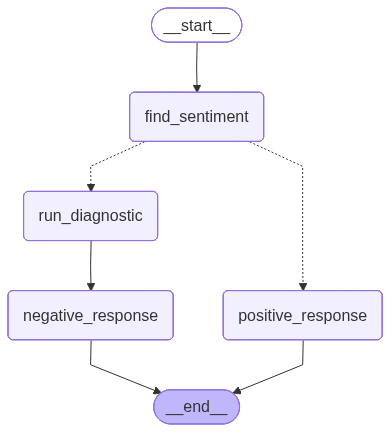

In [62]:
graph = StateGraph(SentimentState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnostic',run_diagnostic)
graph.add_node('negative_response',negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnostic', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()
Image(workflow.get_graph().draw_mermaid_png())

In [68]:
positive_review = {'review':"""I've been a member at FitZone for six months now and it's honestly been such a great decision. The equipment is always well-maintained and there's enough variety that I never feel bored with my workouts. What really stands out is how clean everything is—the staff is constantly wiping down machines and the locker rooms are spotless. The 24-hour access has been a lifesaver for my weird work schedule, and I've never had to wait more than a few minutes for a squat rack, even during peak hours. The trainers are knowledgeable without being pushy, and there's a genuinely supportive atmosphere where people encourage each other. For the price, it's an incredible value and I actually look forward to going."""}
positive_reponse = workflow.invoke(positive_review)

In [69]:
positive_reponse.keys()

dict_keys(['review', 'sentiment', 'response'])

In [70]:
positive_reponse['sentiment']

'positive'

In [72]:
print(positive_reponse['response'])

Subject: Thank You for Your Kind Words!

Dear [Reviewer's Name],

Thank you so much for taking the time to share your wonderful experience at FitZone! We're thrilled to hear that you’re enjoying your membership and finding our facilities to be well-maintained, clean, and accessible. It's fantastic that you appreciate the variety of equipment and the supportive atmosphere we strive to cultivate.

Your feedback is invaluable to us, and we’re grateful for your recognition of our dedicated staff and trainers. We believe that a positive community makes all the difference, and it’s heartwarming to know that you feel encouraged during your workouts.

If you have a moment, we would greatly appreciate it if you could share your thoughts on Google and our website. Your insights could help others discover how FitZone can be a great fit for them too!

Thank you once again for your kind words, and we look forward to seeing you in the gym!

Best regards,  
[Your Name]  
[Your Position]  
FitZone


In [82]:
negative_review = {'review':"""I had high hopes when I signed up for PowerHouse Gym, but it's been nothing but disappointment. The equipment is constantly broken—the same treadmill has had an "out of order" sign on it for three weeks. It's impossibly crowded between 5-7pm, to the point where I've given up and gone home multiple times because I couldn't access any of the machines I needed. The worst part is the predatory contract—they make canceling nearly impossible and keep charging your card even after you've submitted cancellation paperwork. The locker rooms are grimy, there's never enough towels, and the air conditioning barely works in the summer. Staff turnover seems really high, so no one knows what's going on. I'm stuck in a year-long contract and counting down the days until I can leave."""}
negative_reponse = workflow.invoke(negative_review)

In [83]:
negative_reponse.keys()

dict_keys(['review', 'sentiment', 'diagnostic', 'response'])

In [84]:
negative_reponse['sentiment']

'negative'

In [85]:
negative_reponse['diagnostic']

{'issue_type': 'Equipment', 'tone': 'frustated', 'urgency': 'high'}

In [87]:
print(negative_reponse['response'])

I understand that you're facing an equipment issue and that it’s causing frustration. I want to help you resolve this as quickly as possible. Could you please provide me with more details about the equipment problem you're experiencing? This will allow me to assist you more effectively.
